# IFU立方体拟合

# 使用场景

应用方向：AGN（活动星系核）的连续谱和发射线建模；波长范围 1.47-1.87 微米。

数据：NIFS （双子座望远镜上的近红外积分场光谱仪）；观测目标：NGC 4151。

工具：specutils、jdaviz/cubeviz、astropy、matplotlib、bottleneck。

跨仪器兼容性：NIRSpec；潜在适用于 MIRI。

文档：本笔记本是 STScI JWST 后管道数据分析工具生态系统的一部分，可直接从 JDAT Notebook Github 目录 下载。

---

# 简介

本笔记本使用 NGC 4151 活动星系核 的 3D IFU 数据立方示例（Storchi-Bergmann et al. 2009, MNRAS, V 394, pp. 1148-1166）。该数据集是在 双子座天文台（Gemini） 采用 近红外积分场光谱仪（NIFS） 观测的 自适应光学（AO）H 波段（1.47-1.87 µm） 数据集。NIFS 是一种与 JWST NIRSpec 结构相似的 图像切片式 IFU 仪器。

本笔记本执行了一些基础的光谱分析任务：

- 使用 jdaviz/cubeviz 检查数据集并提取 1D 光谱。
- 在靠近 1.644 µm 的 [Fe II] 发射线 附近进行 连续谱拟合 并将其扣除。
- 由于 H I Brackett 12 原子氢发射线（紧邻 [Fe II] 发射线）会对 [Fe II] 流出物产生污染，因此对其进行 拟合并去除。
- 生成的数据子立方包括：
  - 连续谱模型
  - 扣除连续谱后的 [Fe II] 纯发射线
  - 这些处理后的数据集将作为 后续笔记本分析的起点。

注意：本笔记本的默认分析目标是 1.6440 µm 的 [Fe II] 发射线，但可以调整波长范围，以适用于任何感兴趣的发射线的连续谱拟合与扣除。

---

# 导入相关工具包

- time —— 计算代码运行时间
- numpy —— 数组处理和数学计算
- matplotlib.pyplot —— 绘制图像和光谱
- astropy.io —— 读取和写入 FITS 立方数据与图像
- astropy.modeling —— 光谱曲线建模
- astropy.utils.data —— 访问数据文件
- specutils.fitting —— 光谱数据拟合
- specutils Spectrum1D —— 用于建模发射线
- jdaviz —— 在笔记本中使用 cubeviz 进行 IFU 数据分析

In [1]:
# 导入重要的包

import os  # 导入操作系统相关的功能

import time  # 导入时间相关的功能

from IPython.display import YouTubeVideo  # 导入用于显示YouTube视频的功能

import warnings  # 导入警告相关的功能

import numpy as np  # 导入NumPy库，用于数值计算

from astropy.io import fits  # 导入Astropy库中的FITS文件处理功能

from astropy import units as u  # 导入Astropy库中的单位处理功能

from astropy.modeling.functional_models import Gaussian1D  # 导入高斯模型

from astropy.utils.data import download_file  # 导入用于下载文件的功能

from specutils import Spectrum1D  # 导入Spectrum1D类，用于处理光谱数据

from jdaviz import Cubeviz  # 导入Cubeviz，用于数据可视化

from specutils.manipulation import extract_region  # 导入提取光谱区域的功能

from specutils.spectra import SpectralRegion  # 导入光谱区域类

from regions import PixCoord, CirclePixelRegion  # 导入像素坐标和圆形像素区域类

from glue.core.roi import XRangeROI  # 导入X范围感兴趣区域类

In [2]:
import jdaviz  # 导入jdaviz库，用于数据可视化和分析

print(jdaviz.__version__)  # 打印jdaviz库的版本号

4.1.1


In [3]:
# 加载并配置matplotlib

%matplotlib inline  # 在Jupyter Notebook中内联显示图形

import matplotlib.pyplot as plt  # 导入matplotlib.pyplot模块用于绘图

plt.rcParams.update({'figure.max_open_warning': 0})  # 更新配置，禁止最大打开图形警告

In [4]:
# 使用Pickle保存和加载对象（需要在最后获取参数文件）

import pickle  # 导入pickle模块，用于对象的序列化和反序列化

def save_obj(obj, name):
    # 保存对象到文件
    with open(name, 'wb') as f:  # 以二进制写入模式打开文件
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)  # 使用最高协议将对象写入文件

def load_obj(name):
    # 从文件加载对象
    with open(name, 'rb') as f:  # 以二进制读取模式打开文件
        return pickle.load(f)  # 反序列化并返回对象

In [10]:
看起来您提到的“crval3”可能是与天文学数据处理相关的一个参数，通常用于描述坐标系统中的某个值。为了更好地帮助您，我需要更多的上下文或代码示例。如果您能提供相关的代码或具体的功能需求，我将能够为您添加中文注释并保持代码结构不变。请提供更多信息！

14766.4

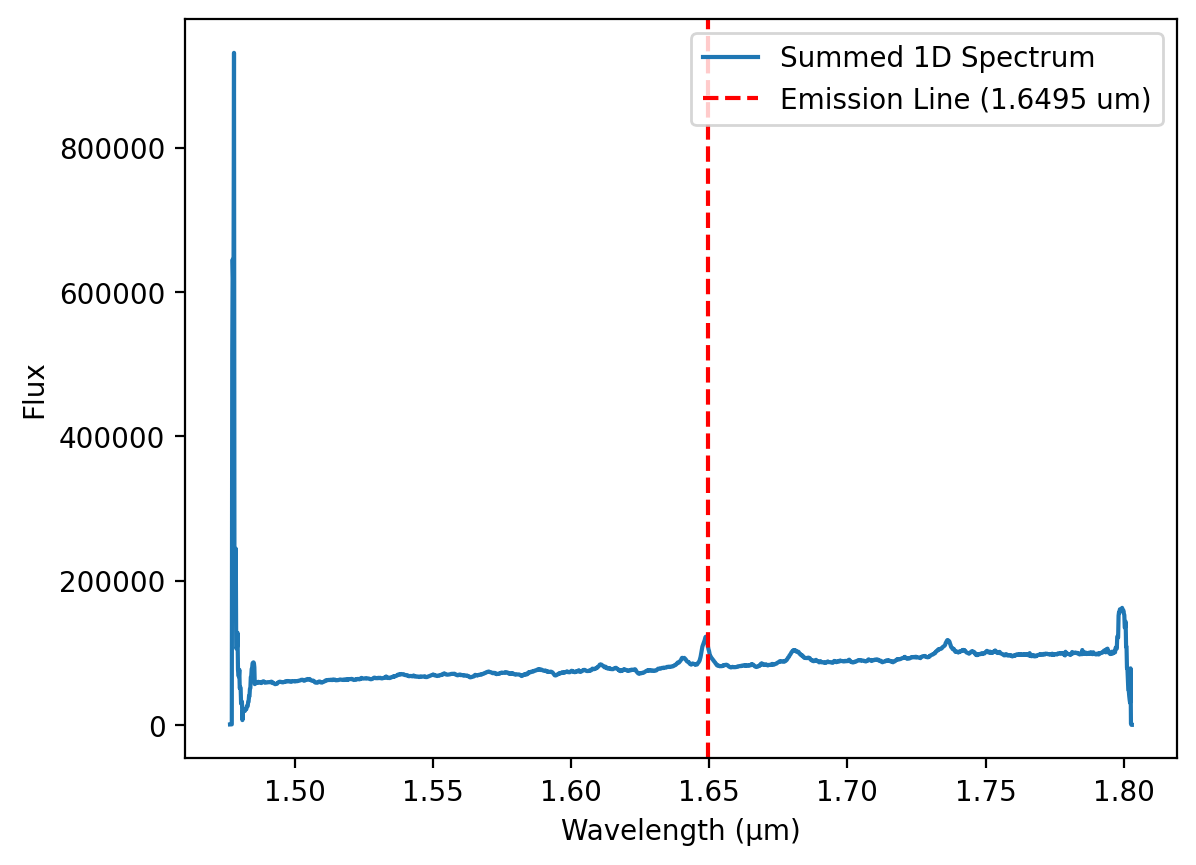

In [11]:
# 该代码单元用于访问 IFU（Integral Field Unit）数据立方（datacube）文件，
# 从 FITS 文件头信息中定义波长网格，并绘制简单的 1 维光谱（即对 IFU 数据进行光谱求和）。

# 导入必要的库
import numpy as np  # 导入 NumPy 库，用于数值计算
import matplotlib.pyplot as plt  # 导入 Matplotlib 库，用于绘图
from astropy.io import fits  # 从 Astropy 库导入 FITS 文件处理模块
from astropy.utils.data import download_file  # 从 Astropy 库导入下载文件的工具

# 读取一个感兴趣的 3D IFU 数据立方文件以及其 FITS 头信息。
# 这里的数据文件是 JWST 观测的 NGC 4151 星系的 H 波段 IFU 立方数据。
cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'

# 下载数据文件，并启用缓存以避免重复下载
fn = download_file(cube_file, cache=True)  # 下载文件并缓存

# 使用 astropy.io.fits 读取 FITS 数据立方体
cube = fits.getdata(fn)  # 获取数据立方体（3D 数据）
header_cube = fits.getheader(fn)  # 获取 FITS 头信息

# 获取数据立方体的维度信息
nz, ny, nx = cube.shape  # nz 代表波长维度的切片数，ny 和 nx 代表空间维度（图像的高度和宽度）

# 从 FITS 头信息中提取波长轴的关键字：
# CDELT3: 每个通道的波长间隔（单位为 Ångström）
# CRVAL3: 波长轴的零点（起始波长，单位为 Ångström）
crdelt3 = header_cube['CDELT3']  # 读取波长步长（通道间隔）
crval3 = header_cube['CRVAL3']  # 读取波长起始值

# 根据 FITS 头信息定义波长网格：
# 使用 numpy.arange 生成从 0 到 nz-1 的整数索引，并计算每个波长通道的实际波长。
# 最后将波长单位从 Ångström 转换为微米（um）。
wave = ((crdelt3 * np.arange(nz)) + crval3) / 10000.0  # 转换单位 Ångström → 微米（1 Å = 0.0001 µm）

# 定义活动星系核（AGN）的红移值
redshift = 0.00332  # NGC 4151 的已知红移

# 选定感兴趣的发射线：
# 这里选择 [Fe II] 1.644 μm（即 1.64400 微米）发射线，
# 并考虑红移效应，即计算观测到的波长
emission_line = 1.64400 * (1 + redshift)  # 计算红移后波长（单位：微米）

# 找到最接近该发射线的波长索引：
# np.abs(wave - emission_line) 计算波长数组中所有元素与发射线波长的差值，
# np.argmin() 找到该差值最小的索引，即最接近该发射线的位置。
emission_line_index = np.abs(wave - emission_line).argmin()  # 找到最接近发射线的波长索引

# 计算整个 IFU 数据立方的总光谱：
# 对数据立方体在空间维度（y 和 x）上进行求和，得到 1 维光谱。
flux1 = np.sum(cube, axis=(1, 2))  # 对每个波长通道的所有像素求和，得到总光谱

# 绘制 1 维光谱
plt.figure(0)  # 创建新图形
plt.plot(wave, flux1, label='Summed 1D Spectrum')  # 绘制波长 vs. 总光谱
plt.axvline(emission_line, color='red', linestyle='--', label=f'Emission Line ({emission_line:.4f} um)')  # 标出发射线位置
plt.xlabel('Wavelength (µm)')  # x 轴标签：波长（微米）
plt.ylabel('Flux')  # y 轴标签：光通量
plt.legend()  # 显示图例
plt.show()  # 显示图像

我们观察到，累加后的 1D 光谱在光谱两端表现出明显的噪声波动（“ratty”）。这一 1D 光谱数据数组超出了仪器的标称可用数据范围。因此，我们将忽略这些质量较差的光谱区域，并专注于活动星系核（AGN, Active Galactic Nucleus）的光通量分析。

我们感兴趣的 [Fe II] 发射特征是一个位于 1.65 微米短波端的明亮而强烈的发射线。需要注意的是，H I Brackett 12 发射线位于 [Fe II] 线的蓝侧，对其造成一定的污染。

我们可以利用光谱图窗口来读取感兴趣的波长值，以便定义分析所需的光谱范围（可参考光谱图右下角的波长/光通量网格数据）。

特别说明：在此数据集中，[Fe II] 发射线红侧（长波方向）的一部分光谱区域提供了一个较为干净的连续谱测量。然而，在 [Fe II] 和 H I Brackett 12 发射线的蓝侧（短波方向），存在其他的发射和吸收特征，使得明确识别连续谱变得非常困难。因此，相比于采用包含整个发射线的更大波长范围，在红侧区域进行简单的线性拟合会更加准确。

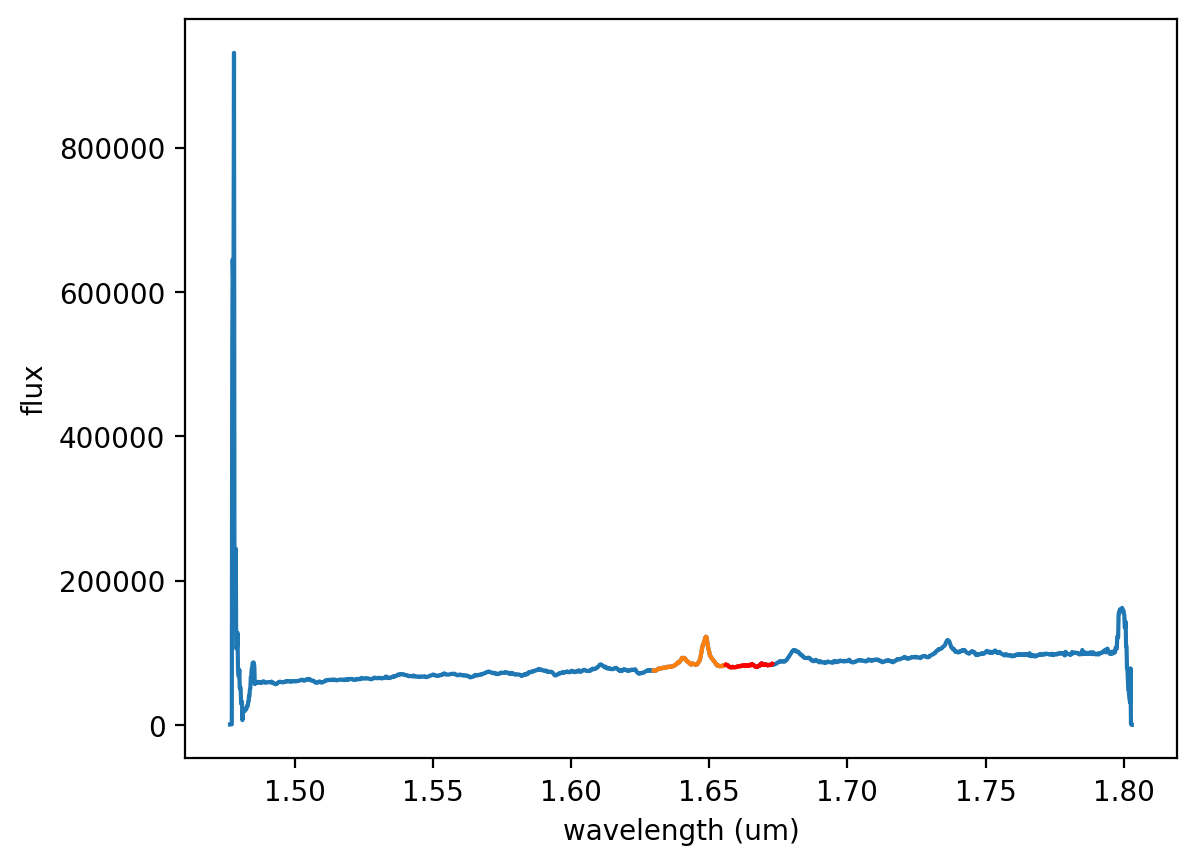

In [12]:
# 该单元定义了感兴趣的波长区域：围绕发射线的区域，以及
# 你想要非常准确地拟合和去除连续体的位置。绘制一个图，显示这些区域。

# 在这里我们选择一个包含发射线的区域
# 波长以及其周围的连续体的小范围。

# 通过调查上面图中的通量来确定这些限制。
# 从右下角的图信息中读取波长值。

wave_emission_limit1 = 1.630  # 发射线下限波长
wave_emission_limit2 = 1.665  # 发射线上限波长

# 在这里我们定义一个光谱范围，在该范围内我们将使用
# 通量生成连续体模型。该
# AGN在红移发射线附近的通量形状相当线性，因此我们将仅使用
# 发射特征红侧的短段光谱。

# 我们再次通过调查上面图窗口中的波长来确定这些值。

continuum_limit1 = 1.656  # 连续体下限波长
continuum_limit2 = 1.673  # 连续体上限波长

# 定义发射线周围的波长区域 - 索引
wavemin = (np.abs(wave - wave_emission_limit1)).argmin()  # 找到发射线下限的索引
wavemax = (np.abs(wave - wave_emission_limit2)).argmin()  # 找到发射线上限的索引

# 定义用于拟合连续体通量水平的波长区域 - 索引
continuummin = (np.abs(wave - continuum_limit1)).argmin()  # 找到连续体下限的索引
continuummax = (np.abs(wave - continuum_limit2)).argmin()  # 找到连续体上限的索引

# 显示用于发射线和连续体拟合的区域。如果看起来不合适，请更改上面的波长。
plt.figure(1)  # 创建新的图形
plt.plot(wave, flux1)  # 绘制整个光谱
plt.plot(wave[wavemin:wavemax], flux1[wavemin:wavemax])  # 绘制发射线区域
plt.plot(wave[continuummin:continuummax], flux1[continuummin:continuummax], color='r')  # 绘制连续体区域，红色
plt.xlabel('wavelength (um)')  # 设置x轴标签
plt.ylabel('flux')  # 设置y轴标签
plt.show()  # 显示图形

### Cubeviz 可视化

您还可以使用 [Cubeviz](https://jdaviz.readthedocs.io/en/latest/cubeviz/index.html) 在 Jupyter Notebook 中可视化图像。

### 视频：

此Cubeviz演示来自官方JWST观察者YouTube频道。它展示了如何使用Cubeviz进行特定科学案例的示例（并非本笔记本中的科学案例）。

In [ ]:
vid = YouTubeVideo("ayb6OkmZUwU")  # 创建一个YouTubeVideo对象，传入视频ID

display(vid)  # 显示该YouTube视频

In [ ]:
# 导入Cubeviz类
cubeviz = Cubeviz()  # 创建Cubeviz实例

# 显示Cubeviz界面
cubeviz.show()  # 调用show方法以显示界面

In [ ]:
# 在这里，我们将数据加载到Cubeviz应用程序中。

with warnings.catch_warnings():  # 捕获警告
    warnings.simplefilter('ignore')  # 忽略警告

    cubeviz.load_data(fn)  # 加载数据文件fn到Cubeviz

下面的视频展示了该过程。以下步骤适用：

当您加载立方体时，您将在底部的光谱查看器中看到所有spaxels的合并光谱。

如果您在通量查看器中绘制一个区域（圆形或方形），您也会在光谱查看器中看到该特定区域的合并光谱。在这个例子中，我们首先要在明亮的活动星系核（AGN）通量的中心位置定义一个圆形区域，该位置大约位于立方体的中心。<br>

<img src='./cubeviz_select_subset.png' alt="在图像中心的AGN上选择一个圆形子集。" width="500"/>

现在，使用通量查看器，再次使用“定义感兴趣的圆形区域”图标，在与[Fe II]的喷流发射相关的两个位置制作光谱。红移喷流大约位于x位置 = 12，y位置 = 36。这将是“子集2”，在显示中将以绿色显示。蓝移喷流大约位于像素索引单位的x位置 = 48，y位置 = 24。这将是“子集3”，在显示中将以蓝色显示。_提示：光标的坐标在工具的顶部报告_<br>

<img src='./cubeviz_select_subset_outflow.png' alt="在AGN两侧选择一个圆形子集以观察喷流。" width="500"/>

## 定义你的光谱区域

接下来，你需要在光谱查看器中定义你感兴趣的波长，以便进行线和连续谱分析。为此，你同样需要点击光谱查看器中的“定义感兴趣区域”图标，并拖动一个框覆盖你所需的波长。线发射（'Subset 4'）应大致覆盖1.630 - 1.665微米，而连续发射（'Subset 5'）应大致覆盖1.656 - 1.673微米。<br>

<img src='./cubeviz_select_spectral_subset.png' alt="选择发射特征上的光谱子集和连续谱上的光谱子集。" width="500"/><br>

_提示：子集可以在子集工具插件中进行修改_

### 一些注意事项：

* 如果您的单元窗口需要滚动才能查看cubeviz中的不同显示，您可以在笔记本的主菜单中切换滚动窗口：单元 -> 当前输出 -> 切换滚动

* 为了更好地可视化立方体，您可以在绘图选项插件中更改显示选项。

# 在Cubeviz光谱查看器中提取子集光谱

从光谱查看器中检索用户定义区域的光谱，作为Spectrum1D对象。首先，我们通过API创建区域，以防笔记本未以交互方式运行。

In [ ]:
# 创建空间区域

spatial_regions = cubeviz.get_interactive_regions()  # 获取当前的交互区域

if 'Subset 1' not in spatial_regions.keys():  # 检查是否存在子集1

    agn_region = CirclePixelRegion(center=PixCoord(x=29, y=29), radius=6)  # 创建AGN区域，中心点为(29, 29)，半径为6

    cubeviz.load_regions(agn_region)  # 加载AGN区域

if 'Subset 2' not in spatial_regions.keys():  # 检查是否存在子集2

    redshifted_outflow = CirclePixelRegion(center=PixCoord(x=12, y=36), radius=6)  # 创建红移外流区域，中心点为(12, 36)，半径为6

    cubeviz.load_regions(redshifted_outflow)  # 加载红移外流区域

if 'Subset 3' not in spatial_regions.keys():  # 检查是否存在子集3

    blueshifted_outflow = CirclePixelRegion(center=PixCoord(x=48, y=24), radius=6)  # 创建蓝移外流区域，中心点为(48, 24)，半径为6

    cubeviz.load_regions(blueshifted_outflow)  # 加载蓝移外流区域

spatial_regions = cubeviz.get_interactive_regions()  # 再次获取当前的交互区域

spatial_regions  # 返回当前的空间区域

默认情况下，光谱是使用 `sum` 函数和光谱提取插件中的默认选项提取的。为了本笔记本的目的，我们希望使用 `mean` 函数提取光谱。我们可以通过界面进行操作，如下方截图所示，或者运行以下单元格。<br>

<img src='./cubeviz_spectral_extraction_plugin.png' alt="打开光谱提取插件，选择空间子集，并选择提取函数 mean。" width="500"/><br>

In [ ]:
spec_ext = cubeviz.plugins['Spectral Extraction']  # 获取光谱提取插件

spec_ext.function = 'Mean'  # 设置提取函数为均值

spec_ext.aperture = 'Subset 1'  # 设置光圈为子集1
spec_ext.add_results = 'Spectrum (Subset 1, mean)'  # 添加结果标签
spec_ext.extract()  # 执行提取操作

spec_ext.aperture = 'Subset 2'  # 设置光圈为子集2
spec_ext.add_results = 'Spectrum (Subset 2, mean)'  # 添加结果标签
spec_ext.extract()  # 执行提取操作

spec_ext.aperture = 'Subset 3'  # 设置光圈为子集3
spec_ext.add_results = 'Spectrum (Subset 3, mean)'  # 添加结果标签
spec_ext.extract()  # 执行提取操作

In [ ]:
# 从cubeviz中提取与彩色区域对应的光谱

spectrum1 = cubeviz.get_data("Spectrum (Subset 1, mean)") # 获取AGN中心的光谱

spectrum2 = cubeviz.get_data("Spectrum (Subset 2, mean)") # 获取红移分量的光谱

spectrum3 = cubeviz.get_data("Spectrum (Subset 3, mean)") # 获取蓝移分量的光谱

spectrum1 # 显示AGN中心的光谱

In [ ]:
# 提取在光谱查看器中定义的线区域

regions = cubeviz.specviz.get_spectral_regions()  # 获取当前光谱区域

if "Subset 4" in regions.keys():  # 检查是否存在名为"Subset 4"的区域
    line_region = regions["Subset 4"]  # 如果存在，获取该区域
else:  # 如果不存在
    line_region = SpectralRegion(1.630*u.um, 1.665*u.um)  # 创建一个新的光谱区域，范围为1.630到1.665微米

    sv = cubeviz.app.get_viewer('spectrum-viewer')  # 获取光谱查看器

    sv.toolbar_active_subset.selected = []  # 清空当前活动子集的选择

    sv.apply_roi(XRangeROI(16300, 16650))  # 应用一个新的感兴趣区域，范围为16300到16650

In [ ]:
# 提取在光谱查看器中定义的连续区域

if "Subset 5" in regions.keys():  # 检查是否存在名为"Subset 5"的区域

    continuum_region = regions["Subset 5"]  # 如果存在，获取该区域

else:  # 如果不存在

    continuum_region = SpectralRegion(1.656*u.um, 1.673*u.um)  # 定义一个新的连续区域

    sv = cubeviz.app.get_viewer('spectrum-viewer')  # 获取光谱查看器

    sv.toolbar_active_subset.selected = []  # 清空当前活动子集的选择

    sv.apply_roi(XRangeROI(16560, 16730))  # 应用一个新的感兴趣区域（ROI）

regions = cubeviz.specviz.get_spectral_regions()  # 获取当前的光谱区域

regions  # 返回光谱区域

In [ ]:
# 应用光谱区域

# （如果用户没有在jdaviz中创建新的折叠光谱，则创建新的折叠光谱）

if not spectrum1:  # 检查spectrum1是否存在

    # 计算AGN的光通量，选择中心区域的像素进行求和
    flux_agn = np.sum(cube[:, (ny//2)-3:(ny//2)+3, (nx//2)-3:(nx//2)+3], axis=(1, 2))

    # 创建一个新的Spectrum1D对象，包含计算得到的光通量和波长
    tmpspec = Spectrum1D(flux=flux_agn*u.Unit('count'), spectral_axis=wave*u.micron) 

    # 从临时光谱中提取线区域
    spec_agn = extract_region(tmpspec, line_region)

    # 从临时光谱中提取连续区域
    spec_agn_continuum = extract_region(tmpspec, continuum_region)    

else:  # 如果spectrum1存在

    # 从spectrum1中提取线区域
    spec_agn = extract_region(spectrum1, line_region)

    # 从spectrum1中提取连续区域
    spec_agn_continuum = extract_region(spectrum1, continuum_region)

if not spectrum2:  # 检查spectrum2是否存在

    # 计算红光FeII的光通量，选择特定像素区域进行求和
    flux_feii_red = np.sum(cube[:, (36)-3:(36)+3, (12)-3:(12)+3], axis=(1, 2))

    # 创建一个新的Spectrum1D对象，包含计算得到的光通量和波长
    tmpspec = Spectrum1D(flux=flux_feii_red*u.Unit('count'), spectral_axis=wave*u.micron) 

    # 从临时光谱中提取线区域
    spec_feii_red = extract_region(tmpspec, line_region)

    # 从临时光谱中提取连续区域
    spec_feii_red_continuum = extract_region(tmpspec, continuum_region)

else:  # 如果spectrum2存在    

    # 从spectrum2中提取线区域
    spec_feii_red = extract_region(spectrum2, line_region)

    # 从spectrum2中提取连续区域
    spec_feii_red_continuum = extract_region(spectrum2, continuum_region)

if not spectrum3:  # 检查spectrum3是否存在

    # 计算蓝光FeII的光通量，选择特定像素区域进行求和
    flux_feii_blue = np.sum(cube[:, (28)-3:(28)+3, (50)-3:(50)+3], axis=(1, 2))

    # 创建一个新的Spectrum1D对象，包含计算得到的光通量和波长
    tmpspec = Spectrum1D(flux=flux_feii_blue*u.Unit('count'), spectral_axis=wave*u.micron) 

    # 从临时光谱中提取线区域
    spec_feii_blue = extract_region(tmpspec, line_region)

    # 从临时光谱中提取连续区域
    spec_feii_blue_continuum = extract_region(tmpspec, continuum_region)

else:  # 如果spectrum3存在     

    # 从spectrum3中提取线区域
    spec_feii_blue = extract_region(spectrum3, line_region)

    # 从spectrum3中提取连续区域
    spec_feii_blue_continuum = extract_region(spectrum3, continuum_region)

In [ ]:
# 可视化新的子集

plt.figure()  # 创建一个新的图形

plt.plot(spec_agn.spectral_axis, spec_agn.flux, color='black')  # 绘制光谱轴与通量的关系，颜色为黑色

plt.title('Spectrum subset 1')  # 设置图形标题

plt.xlabel('wavelength')  # 设置x轴标签为波长

plt.ylabel('flux')  # 设置y轴标签为通量

In [ ]:
# 可视化新的子集

plt.figure()  # 创建一个新的图形

plt.plot(spec_feii_blue.spectral_axis, spec_feii_blue.flux, color='b')  # 绘制蓝色Fe II谱线

plt.plot(spec_feii_red.spectral_axis, spec_feii_red.flux, color='r')  # 绘制红色Fe II谱线

plt.title('Spectra subset 2 and 3')  # 设置图形标题

plt.xlabel('wavelength')  # 设置x轴标签为波长

plt.ylabel('flux')  # 设置y轴标签为通量

## 在光谱区域位置拟合连续谱

打开模型拟合插件。这里有多个字段需要填写和下拉菜单供选择。重要的是要记住，数据菜单将仅提供可用于建模的光谱，而光谱区域菜单将仅提供可供选择的光谱区域子集。换句话说，您可以在特定的光谱区域内拟合光谱。如果未选择光谱区域，则整个波长数组将由该模式拟合。<br />

我们将首先拟合一个单独的光谱，以测试我们的拟合参数是否合适，然后我们将切换到拟合整个立方体。 </br>

**单个光谱**

选择数据：光谱子集 1（均值）<br>

选择光谱区域：子集 5<br>

模型：Linear1D（线性一维）<br>

ModelID（模型ID）：L<br>

点击“添加组件”<br>

模型参数：保持默认<br>

模型方程编辑器：L<br>

模型标签：LinFitCont<br>

点击“拟合模型”，这将拟合压缩后的光谱。<br>

在光谱查看器中查看拟合结果，并确认您对此满意。<br>

**整个立方体**

在顶部切换“立方体拟合”。</br>

将名称更改为 LinFitCont_cube，然后再次点击“拟合模型”。<br>

<img src='./cubeviz_model_fitting.png' alt="模型拟合可以在插件中设置。" width="700"/>

拟合后的立方体可以在2D查看器的数据下拉菜单中访问。

### 使用API替代

In [ ]:
models = cubeviz.get_models()  # 获取当前模型

if 'LinFitCont' in models.keys():  # 检查是否存在线性拟合模型
    singlemodel = models['LinFitCont']  # 如果存在，获取该模型
else:
    # 打开模型拟合插件
    plugin_mf = cubeviz.plugins['Model Fitting']  # 获取模型拟合插件
    plugin_mf.open_in_tray()  # 在插件托盘中打开

    # 输入适当的数据集
    plugin_mf.dataset = 'Spectrum (sum)'  # 设置数据集为总光谱
    plugin_mf.spectral_subset = 'Subset 5'  # 设置光谱子集为子集5

    # 输入模型组件
    plugin_mf.create_model_component(model_component='Linear1D',  # 创建线性一维模型组件
                                     model_component_label='L1')  # 设置模型组件标签为L1

    # 模型方程会自动填充
    plugin_mf.equation = 'L1'  # 设置模型方程为L1

    # 运行后，我们去GUI检查拟合是否合理
    plugin_mf.add_results.label = 'LinFitCont'  # 设置结果标签为LinFitCont
    plugin_mf.cube_fit = False  # 设置为非立方体拟合
    plugin_mf.calculate_fit()  # 计算拟合

if 'LinFitCont_cube (30, 30)' in models.keys():  # 检查是否存在立方体线性拟合模型
    cubemodel = models['LinFitCont_cube']  # 如果存在，获取该模型
else:
    # 打开模型拟合插件
    plugin_mf = cubeviz.plugins['Model Fitting']  # 获取模型拟合插件
    plugin_mf.open_in_tray()  # 在插件托盘中打开

    # 设置拟合为立方体
    plugin_mf.cube_fit = True  # 设置为立方体拟合

    # 输入适当的数据集
    plugin_mf.dataset = 'contents[SCI]'  # 设置数据集为科学数据内容
    plugin_mf.spectral_subset = 'Subset 5'  # 设置光谱子集为子集5

    # 输入模型组件
    plugin_mf.create_model_component(model_component='Linear1D',  # 创建线性一维模型组件
                                     model_component_label='L2')  # 设置模型组件标签为L2

    # 模型方程会自动填充
    plugin_mf.equation = 'L2'  # 设置模型方程为L2

    # 运行后，我们去GUI检查拟合是否合理
    plugin_mf.add_results.label = 'LinFitCont_cube'  # 设置结果标签为LinFitCont_cube
    plugin_mf.calculate_fit()  # 计算拟合

In [ ]:
models = cubeviz.get_models()  # 获取模型数据

# models  # 注释掉的代码，可能用于调试或查看模型

models['LinFitCont_cube (30, 30)']  # 访问特定的线性拟合模型

## 拉取其他数据

请注意，在 cubeviz 中，您可以通过使用 `function` 关键字参数（可选地）结合 `spatial_subset` 来返回如上所述的合并光谱，或者通过省略这些关键字来返回整个数据立方体，如下所示。

In [ ]:
# 列出可用的数据
print(cubeviz.data_labels)  # 打印数据标签

# 获取完整的原始数据立方体
scidata = cubeviz.get_data("contents[SCI]")  # 从cubeviz中获取科学数据

scidata  # 显示获取的数据

In [ ]:
# 从Cubeviz中提取SCI立方体和连续模型，并制作连续减去的立方体

if 'LinFitCont_cube' in cubeviz.app.data_collection:  # 检查数据集中是否包含'LinFitCont_cube'

    cont_psf_cube = cubeviz.get_data("LinFitCont_cube")  # 获取连续模型立方体

    print('Check shape of the objects')  # 打印检查对象的形状

    print(scidata.shape)  # 打印科学数据立方体的形状

    print(cont_psf_cube.shape)  # 打印连续模型立方体的形状

    # 获取连续减去的立方体

    sci_contsub = scidata - cont_psf_cube  # 从科学数据中减去连续模型

    # 保存到文件

    # sci_contsub.write('NGC4151_Hband_ContinuumSubtract.fits', format='wcs1d-fits', overwrite=True)  # 保存连续减去的立方体到文件

    # cont_psf_cube.write('NGC4151_Hband_ContinuumPSF.fits', format='wcs1d-fits', overwrite=True)  # 保存连续模型立方体到文件

**开发者备注**：<br>

- 如果我尝试将立方体保存到文件中，会出现回溯错误，因为它们没有正确的头文件。

In [ ]:
# 在Cubeviz中查看去除连续谱的立方体数据

if sci_contsub:  # 检查是否存在去除连续谱的数据

    with warnings.catch_warnings():  # 捕获警告

        warnings.simplefilter('ignore')  # 忽略警告

        cubeviz2 = Cubeviz()  # 创建Cubeviz实例

        cubeviz2.load_data(sci_contsub, data_label='Continuum Subtracted')  # 加载去除连续谱的数据，并设置标签

        cubeviz2.show()  # 显示Cubeviz窗口

### 使用numpy进行连续体减法的替代方法

In [ ]:
# 重新读取原始的IFU立方体以进行处理

cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'  # 定义立方体文件的URL

newfn = download_file(cube_file, cache=True)  # 下载文件并缓存

newheader_cube = fits.getheader(cube_file)  # 获取立方体文件的头信息

start_time = time.time()  # 记录开始时间

sci_contsub_np = np.zeros([nx, ny, nz])  # 初始化科学数据的连续体减去数组
cont_psf_cube_np = np.zeros([nx, ny, nz])  # 初始化连续体PSF立方体数组

# 遍历立方体的每个像素
for i in range(1, nx-2):  # 遍历x轴
    for j in range(1, ny-2):  # 遍历y轴
        flux1 = cube[:, j, i]  # 获取当前像素的光谱数据

        cont_fit = np.polyfit(wave[continuummin:continuummax], flux1[continuummin:continuummax], 1)  # 拟合连续体
        fitval = np.poly1d(cont_fit)  # 创建多项式对象

        continuum = fitval(wave)  # 计算连续体

        sci_contsub_np[i, j, :] = flux1 - continuum  # 进行连续体减法
        cont_psf_cube_np[i, j, :] = continuum  # 保存连续体PSF

print(sci_contsub_np.shape)  # 打印科学数据的形状

del newheader_cube['MODE']  # 删除头信息中的'MODE'条目

# 将减去连续体后的立方体和PSF立方体写入新的FITS文件
fits.writeto('NGC4151_Hband_ContinuumSubtract_numpy.fits', sci_contsub_np, newheader_cube, overwrite=True)  # 保存减去连续体后的立方体
fits.writeto('NGC4151_Hband_ContinuumPSF_numpy.fits', cont_psf_cube_np, newheader_cube, overwrite=True)  # 保存连续体PSF立方体

print('Continuum subtracted cube saved. PSF continuum cube saved.')  # 打印保存成功信息

**开发者备注**：

- 新创建的文件无法在Cubeviz中打开

## 拟合您的多组分高斯模型

现在我们想要研究对 Br 12 发射特征的初步拟合，这是一个在波长上与我们的目标 [Fe II] 发射相邻的麻烦污染物。Br 12 是集中紧凑的，仅来自活动星系核（AGN）的核，而不是来自喷流。绘制拟合结果的图。<br />

首先，按照顶部执行的类似程序选择感兴趣的波长区域。没有选项可以设置用户输入的光谱区域，因此我们建议放大并用眼睛绘制。线发射（“子集 1”）应再次大致覆盖 1.630 - 1.665 微米。<br />

<img src='./cubeviz2_subset.png' alt="选择一个在 1.54 微米附近的 3 条线发射特征的光谱子集。" width="500"/><br />

对于这个例子，我们建议设置一个 3 组分的高斯模型，输入如下：<br />

打开模型拟合插件。有许多字段需要填写和下拉菜单可供选择。重要的是要记住，数据菜单将仅提供要建模的光谱，而光谱区域菜单将仅提供可选择的光谱区域子集。换句话说，您可以在特定的光谱区域中拟合光谱。如果未选择光谱区域，则整个波长数组将由模型进行拟合。<br />

数据：光谱（总和）<br />

光谱区域：子集 1<br />

模型：三个不同的高斯，ModelID 设置为 G1、G2 和 G3<br />

模型参数：<br />

G1：标准差=8，均值=16410<br />

G2：标准差=7，均值=16480<br />

G3：标准差=50，均值=16460<br />

如果需要，您可以启用“固定”选项，但这些数字应该为拟合提供一个良好的起始猜测。<br />

模型方程编辑器：G1+G2+G3<br />

模型标签：GaussAll<br />

<br />

点击拟合，这将拟合压缩光谱。<br />

<img src='./cubeviz2_modelfit1.png' alt="准备带有 3 条高斯曲线的拟合参数并拟合压缩光谱。" width="500"/><br />

在光谱查看器中查看拟合结果，并确认您对此感到满意。如有必要，请进行修改。<br />

然后移除“固定”选项，切换到立方体拟合，将名称更改为 GaussAll_cube，并再次运行。<br />

<img src='./cubeviz2_modelfit2.png' alt="准备带有 3 条高斯曲线的拟合参数并拟合压缩光谱。" width="500"/><br />

这将再次创建两个模型，现在可以在数据下拉菜单中访问：<br />

对压缩立方体中线的 1D 线性拟合。<br />

对立方体中每个像素的线的 3D 线性拟合。<br />

哇，那个多组分拟合看起来很棒。真不错。

现在我们将使用前一个单元中的连续体点扩散函数（continuum psf）立方体，结合上面单元中创建的布拉凯特模型（Brackett model），来创建一个完整的三维模型，表示不受流出物[Fe II]影响的中心发射。

**开发者备注**：<br>

- 对整个数据立方体的拟合会卡住，永远无法结束

### 练习

现在你可以尝试调整上面的代码，以通过 API 运行模型拟合！

_提示:_<br>

`plugin_mf.create_model_component(model_component='Gaussian1D', model_component_label='G1')`<br>

`plugin_mf.set_model_component('G1', 'mean', value=16410)`

In [ ]:
请提供您希望我添加中文注释的代码，我将根据您的要求进行处理。

### 从Cubeviz中提取我们需要的内容

In [ ]:
# 提取在光谱查看器中定义的光谱区域
regions = cubeviz2.specviz.get_spectral_regions()  # 从specviz获取光谱区域

print(regions)  # 打印获取的光谱区域

# 检查"Subset 1"是否在光谱区域的键中
if "Subset 1" in regions.keys():
    line_region = regions["Subset 1"]  # 如果存在，获取"Subset 1"对应的光谱区域
else:
    line_region = SpectralRegion(1.630*u.um, 1.665*u.um)  # 如果不存在，定义一个新的光谱区域

In [ ]:
# 列出可用的数据

alldata = cubeviz2.app.data_collection  # 获取数据集合

print(alldata)  # 打印数据集合

print()  # 打印空行以便于阅读

# 列出在光谱查看器中可用的光谱

spec = cubeviz2.specviz.get_spectra()  # 获取可用的光谱

print(spec)  # 打印光谱信息

**开发者说明**：目前无法在创建的模型立方体上使用光谱提取插件。如果需要“均值”模型，则应在提取的“均值”光谱上计算1D模型。

In [ ]:
# 获取高斯模型光谱和模型立方体

spec_ext2 = cubeviz2.plugins['Spectral Extraction']  # 获取光谱提取插件

spec_ext2.function = 'Mean'  # 设置提取函数为均值

spec_ext2.aperture = 'Entire Cube'  # 设置提取区域为整个立方体

spec_ext2.add_results = 'Spectrum entire (mean)'  # 添加结果名称为“整个光谱（均值）”

spec_ext2.extract()  # 执行光谱提取

# 这仅用于后续模型的光谱轴

all_spec = cubeviz2.get_data('Spectrum entire (mean)')  # 获取整个光谱（均值）数据

if 'GaussAll' in alldata:  # 检查数据中是否存在'GaussAll'

    gauss_spec = cubeviz2.get_data('GaussAll')  # 获取AGN中心模型光谱。这是“总和”，而不是“均值”

    print('Model spectrum 1D available')  # 打印模型光谱1D可用信息

    print(gauss_spec)  # 打印高斯光谱

else:

    gauss_spec = False  # 如果不存在，则设置高斯光谱为False

    print('No GaussAll model created')  # 打印未创建GaussAll模型的信息

print()  # 打印空行

if 'GaussAll_cube' in alldata:  # 检查数据中是否存在'GaussAll_cube'

    gauss_cube = cubeviz2.get_data('GaussAll_cube')  # 获取AGN中心模型立方体

    params = cubeviz2.get_model_parameters()  # 获取模型参数

    print('Model spectrum 3D available')  # 打印模型光谱3D可用信息

else:

    gauss_cube = False  # 如果不存在，则设置高斯立方体为False

    params = False  # 设置参数为False

    print('No GaussAll_cube model created')  # 打印未创建GaussAll_cube模型的信息

print()  # 打印空行

# 检查用户是否使用了Cubeviz（如上所示），如果没有，则读取预制数据

if gauss_cube is False:  # 如果高斯立方体为False

    # 获取未使用Cubeviz创建的模型立方体和连续立方体

    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_model_cube.fits', cache=False)  # 下载高斯模型立方体

    tgauss_cube = fits.getdata(fn)  # 获取高斯立方体数据

    gauss_cube = tgauss_cube.transpose(2, 1, 0)  # 转置立方体数据

    print('Shape of downloaded model cube: ', gauss_cube.shape)  # 打印下载的模型立方体形状

    fn_continuum = 'NGC4151_Hband_ContinuumPSF_numpy.fits'  # 设置连续立方体文件名

    continuum_cube = fits.open(fn_continuum, memmap=False)  # 打开连续立方体文件

    newfull_header = fits.getheader(fn_continuum)  # 获取文件头信息

    continuum_data = continuum_cube[0].data  # 获取连续数据

    print('Shape of downloaded continuum cube: ', continuum_data.shape)  # 打印下载的连续立方体形状

else:

    print('Shape of created model cube: ', gauss_cube.shape)  # 打印创建的模型立方体形状

    continuum_data = sci  # 在Cubeviz1中创建的连续数据

    print('Shape of created continuum cube: ', continuum_data.shape)  # 打印创建的连续立方体形状

print()  # 打印空行

if params is False:  # 如果参数为False

    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_params.pkl', cache=True)  # 下载高斯参数文件

    params = load_obj(fn)  # 加载参数对象

    print('Keys of downloaded model parameters: ', params.keys())  # 打印下载的模型参数的键

else:

    print('Keys of created model parameters: ', params.keys())  # 打印创建的模型参数的键

print()  # 打印空行

if not all_spec:  # 如果all_spec为False

    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/all_spec.fits', cache=False)  # 下载所有光谱文件

    all_spec = Spectrum1D.read(fn)  # 读取光谱数据

    print('Shape of downloaded continuum subtracted spectrum: ', all_spec.shape)  # 打印下载的去除连续光谱的形状

else:

    print('Shape of created continuum subtracted spectrum: ', all_spec.shape)  # 打印创建的去除连续光谱的形状

print()  # 打印空行

if gauss_spec is False:  # 如果高斯光谱为False

    fn = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/gauss_spec.fits', cache=False)  # 下载高斯光谱文件

    gauss_spec = Spectrum1D.read(fn)  # 读取高斯光谱数据

    print('Shape of downloaded model spectrum: ', gauss_spec.shape)  # 打印下载的模型光谱形状

else:

    print('Shape of created model spectrum: ', gauss_spec.shape)  # 打印创建的模型光谱形状

In [ ]:
# 用仅包含两个感兴趣成分的高斯模型覆盖原有模型

if 'GaussAll_cube' in alldata:  # 检查数据中是否包含'GaussAll_cube'

    gauss_cube_2component = gauss_cube.flux * 0.  # 初始化一个与gauss_cube相同形状的零数组

    model_label = "GaussAll_cube"  # 设置模型标签为'GaussAll_cube'

    specunit = 1.  # 设置光谱单位为1（无单位）

    ampunit = 1.  # 设置幅度单位为1（无单位）

else:  # 如果'GaussAll_cube'不在数据中

    gauss_cube_2component = gauss_cube * 0.  # 初始化一个与gauss_cube相同形状的零数组

    model_label = "GaussAll_3d"  # 设置模型标签为'GaussAll_3d'

    specunit = u.Angstrom  # 设置光谱单位为埃（Angstrom）

    ampunit = u.Unit('count')  # 设置幅度单位为计数（count）

print(gauss_cube_2component.shape)  # 打印gauss_cube_2component的形状

nx, ny, nz = gauss_cube_2component.shape  # 获取gauss_cube_2component的维度

for i in range(0, nx-1):  # 遍历第一个维度（x轴）

    for j in range(0, ny-1):  # 遍历第二个维度（y轴）

        amp1 = params[model_label]['amplitude_0'][i][j]  # 获取第一个高斯成分的幅度

        amp2 = params[model_label]['amplitude_2'][i][j]  # 获取第二个高斯成分的幅度

        m1 = params[model_label]['mean_0'][i][j]*1E10  # 获取第一个高斯成分的均值并转换为米

        m2 = params[model_label]['mean_2'][i][j]*1E10  # 获取第二个高斯成分的均值并转换为米

        stdev1 = params[model_label]['stddev_0'][i][j]*1E10  # 获取第一个高斯成分的标准差并转换为米

        stdev2 = params[model_label]['stddev_2'][i][j]*1E10  # 获取第二个高斯成分的标准差并转换为米

        g1 = Gaussian1D(amplitude=amp1*ampunit, mean=m1*specunit, stddev=stdev1*specunit)  # 创建第一个高斯模型

        g2 = Gaussian1D(amplitude=amp2*ampunit, mean=m2*specunit, stddev=stdev2*specunit)  # 创建第二个高斯模型

        gauss_cube_2component[i, j, :] = g1(all_spec.spectral_axis) + g2(all_spec.spectral_axis)  # 计算两个高斯模型的和并存储

gauss_cube_2component_spec = Spectrum1D(spectral_axis=all_spec.spectral_axis,  # 创建Spectrum1D对象
                                        flux=gauss_cube_2component * ampunit)  # 设置光谱轴和通量

**注意：** 为什么不一次性对所有成分进行拟合，而是在这里添加连续体成分？

In [ ]:
# 将连续体立方体添加到新的模型立方体中

full_model = gauss_cube_2component_spec + continuum_data  # 将两个立方体相加，生成完整模型

print(full_model.shape)  # 打印完整模型的形状

In [ ]:
# 从模型中减去以创建最终立方体，其中[Fe II]发射被孤立。

# 重新读取原始IFU立方体以进行操作

cube_file = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/IFU_cube_continuum_fit/NGC4151_Hband.fits'  # 定义立方体文件的URL

newfinalsub_header = fits.getheader(cube_file)  # 获取立方体文件的头信息

# 从cubeviz中获取的立方体是scidata

final_sub_cube = scidata.flux.value - full_model.flux.value  # 从scidata中减去模型的flux值以得到最终立方体

final_sub_cube_units = Spectrum1D(spectral_axis=scidata.spectral_axis,  # 创建一个Spectrum1D对象，包含光谱轴和减去模型后的flux值
                                  flux=final_sub_cube*ampunit)  # 将减去模型后的flux值乘以单位以获得最终flux

print(final_sub_cube_units.shape)  # 打印最终立方体的形状

print(scidata.shape)  # 打印原始scidata的形状

In [ ]:
import os  # 导入os模块，用于与操作系统交互

# 删除当前目录中任何现有的输出文件

if os.path.exists("NGC4151_Hband_FinalSubtract.fits"):  # 检查文件是否存在
    os.remove("NGC4151_Hband_FinalSubtract.fits")  # 如果存在，删除该文件
else:
    print("The file does not exist")  # 如果不存在，打印提示信息

if os.path.exists("NGC4151_Hband_ContinuumandBrackettModel.fits"):  # 检查另一个文件是否存在
    os.remove("NGC4151_Hband_ContinuumandBrackettModel.fits")  # 如果存在，删除该文件
else:
    print("The file does not exist")  # 如果不存在，打印提示信息

**开发者注释：** Fits writeto 出现错误。暂时将单元格设为原始格式。

In [ ]:
# 制作最终图表以展示原始光谱、模型拟合和最终的连续体+高斯减去的立方体

plt.figure()  # 创建一个新的图形窗口

plt.xlim([16200, 16650])  # 设置x轴范围

plt.ylim([600, 900])  # 设置y轴范围

plt.plot(all_spec.spectral_axis, continuum_data[30, 30, :], label='Continuum')  # 绘制连续体数据

plt.plot(all_spec.spectral_axis, scidata.flux[30, 30, :], label='Original Data')  # 绘制原始数据

plt.plot(all_spec.spectral_axis, full_model.flux[30, 30, :], label='2 Component Model')  # 绘制2成分模型数据

plt.plot(all_spec.spectral_axis, final_sub_cube_units.flux[30, 30, :]+700*ampunit, label='Model Subtraction+Offset')  # 绘制模型减去后的数据并加上偏移量

plt.legend()  # 显示图例

plt.xlabel('wavelength')  # 设置x轴标签为“波长”

plt.ylabel('flux')  # 设置y轴标签为“通量”

plt.show()  # 显示图形